In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-ticks')
plt.rcParams['font.size'] = 16
sns.set_context(rc = {'patch.linewidth': 0.0})
palette = sns.color_palette(palette='deep').as_hex()

In [75]:
import os
this_directory = os.path.realpath(".")
home_directory = os.path.split(this_directory)[0]
data_directory = os.path.join(home_directory, "data")
images_directory = os.path.join(home_directory, "images")

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.stats as stats

In [19]:
def scree_plot(ax, pca, n_components_to_plot=8, title=None, cumsum=False):
    """Scree plot showing the variance (default) or cumulative variance explained
    for the principal components in a fit sklearn PCA object.
    
    Parameters –––
    ax: matplotlib.axis object
    pca: sklearn.decomposition.PCA object, fitted.
    n_components_to_plot: int
    title: str (optional)
    cumsum: bool (optional)
    """
    if cumsum:
        vals = np.cumsum(pca.explained_variance_ratio_)
        y_label, y_pos = "Cumulative ", -1
    else:
        vals = pca.explained_variance_ratio_
        y_label, y_pos = "", 1
        
    num_components = pca.n_components_
    ind = np.arange(num_components)
    ax.plot(ind, vals, color='blue')
    ax.scatter(ind, vals, color='blue', s=50)

    for i in range(num_components):
        ax.annotate(r"{:2.0f}%".format(vals[i]*100), 
               (ind[i]+(y_pos*0.2), vals[i]+0.005), 
               va="bottom", 
               ha="center", 
               fontsize=12)

    ax.set_xticks(ind)
    ax.set_xticklabels(ind + 1, fontsize=12)
    ax.set_ylim(0, max(vals) + 0.05)
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("{}Variance Explained".format(y_label), fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=16)

In [20]:
!ls ../data

census_raw.pkl            colorado_tracts.json      imputed.pkl
clean.pkl                 extra                     old
clean_n.pkl               featurized.pkl            oz_acs_data_brookings.csv


In [33]:
clean = pd.read_pickle(f"{data_directory}/clean.pkl")
all_eligible = clean[(clean['eligible'] == 1)]
not_picked = clean[(clean['eligible'] == 1) & (clean['oz'] == 0)]
picked = clean[clean['oz'] == 1]

In [70]:
drop_cols = ['population_total2017', 'household_income_median2017',\
    'home_value_median2017', 'age_median2017', 'housing_units_total2017',\
    'geoid', 'oz', 'LICadj', 'eligible']
X_n = not_picked.drop(columns=drop_cols)
X = picked.drop(columns=drop_cols)
features= X_n.columns

## PCA 

In [71]:
pca_objs = []
data = [X, X_n]
for d in data:
    
    std_scaler = StandardScaler()
    std_X = std_scaler.fit_transform(d.values)
    n = 10
    paxPCA = PCA(n_components=n)
    pca_objs.append(paxPCA.fit(std_X))

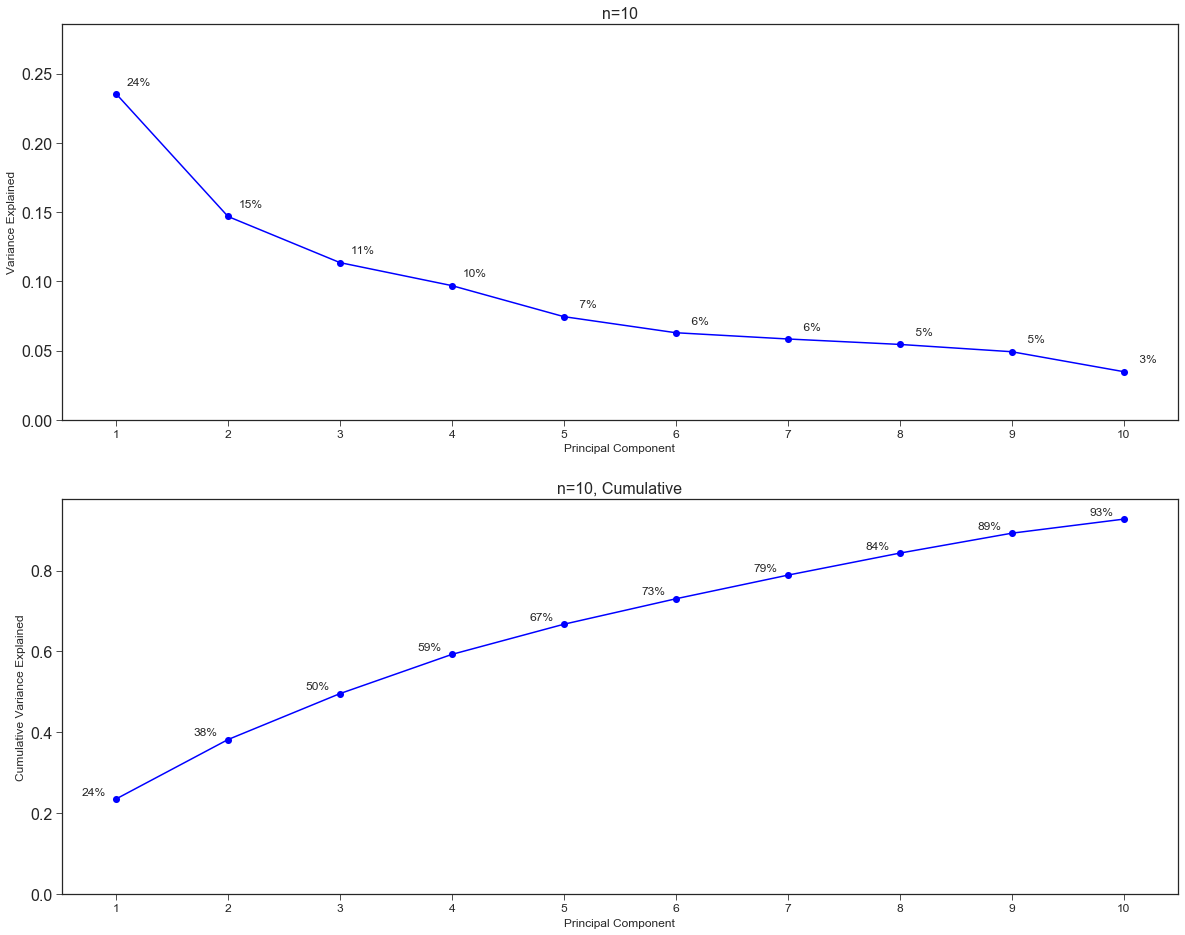

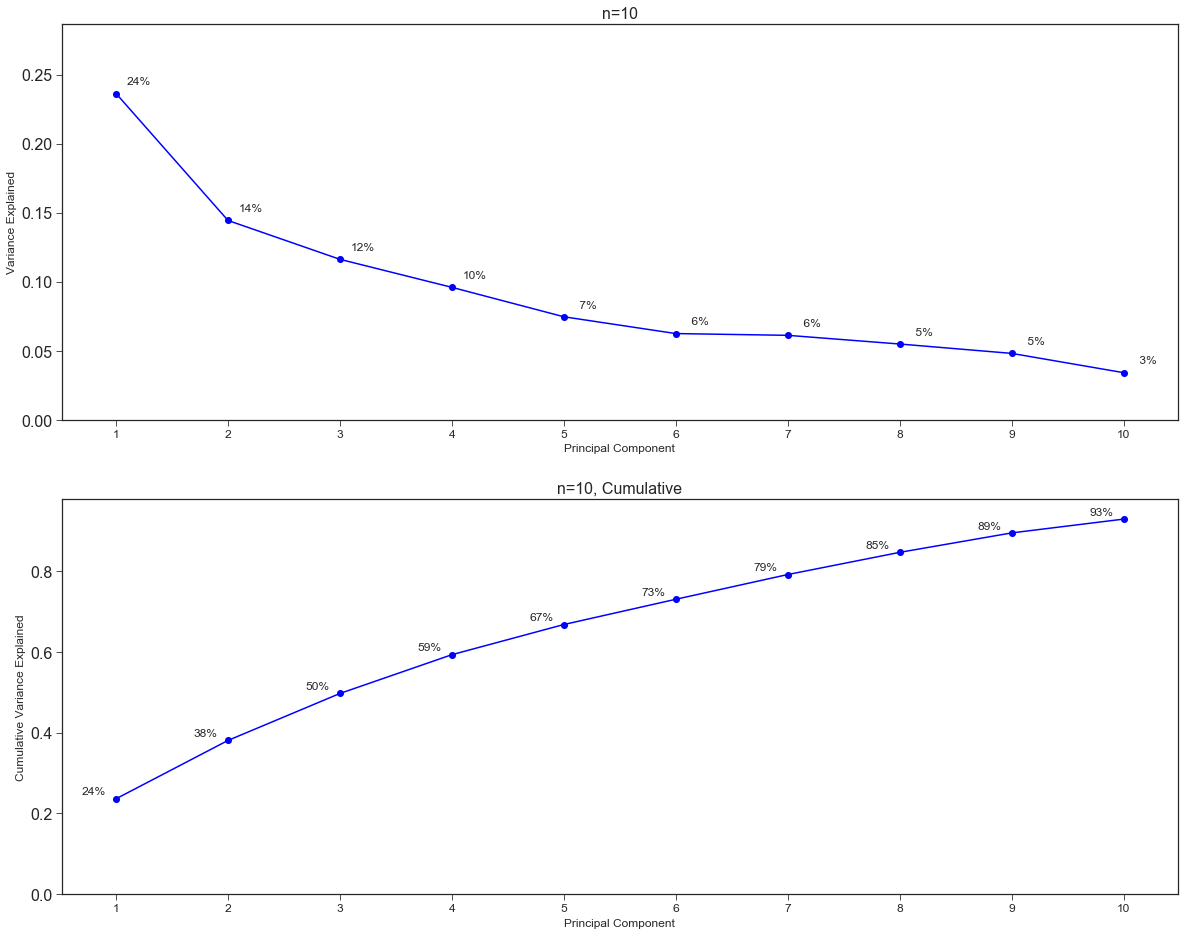

In [72]:
for p in pca_objs:
    f, axes = plt.subplots(2, 1, figsize=(20, 16))
    scree_plot(axes.flatten()[0], p, n_components_to_plot=n, title="n={}".format(n))
    scree_plot(axes.flatten()[1], p, n_components_to_plot=n,\
               title="n={}, Cumulative".format(n), cumsum=True)

Text(0, 0.5, 'PC1')

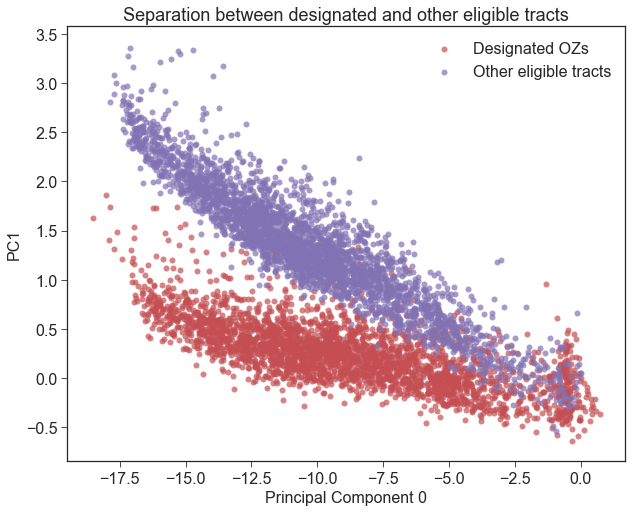

In [73]:
fig, ax = plt.subplots(figsize=(10,8))
labels = ["Designated OZs", "Other eligible tracts"]
n_points = 3000
for i, p in enumerate(pca_objs):
    ## plotting the first two components
    component_a = p.components_[0]
    component_b = p.components_[1]
    x = np.dot(data[i], component_a)[:n_points]
    y = np.dot(data[i], component_b)[:n_points]
    ax.scatter(x, y, color=palette[i+3], alpha=0.7, label=labels[i])
  
ax.legend(fontsize=16)
ax.set_title("Separation between designated and other eligible tracts", fontsize=18)
ax.set_xlabel("Principal Component 0", fontsize=16)
ax.set_ylabel("PC1", fontsize=16)
#plt.savefig("{}/pca_separation.png".format(images_directory), dpi=120, transparent=True)

In [67]:
import scipy.stats as sstats
import statsmodels.stats.weightstats as wstats
## z-test on each component
for c in range(len(pca_objs[0].components_)):
    comp_ai = pca_objs[0].components_[c]
    comp_bi = pca_objs[1].components_[c]
    a = np.dot(data[0], comp_ai)[:n_points]
    b = np.dot(data[1], comp_bi)[:n_points]
    z, p = wstats.ztest(a, b)
    print(z, p)
#     t, p = sstats.ttest_ind(a, b)
#     print(t, p)

12.574806845087611 2.905094624898988e-36
-20.513087008707334 1.6451430898270375e-93
-12.453966920351814 1.3306333562993813e-35
35.07983762876002 1.3684204562296486e-269
34.47358738376182 1.9960817627947303e-260
-0.8954612594445909 0.3705405661893826
199.41623365991938 0.0
-93.70209533358238 0.0
18.435709878984444 6.792138806133239e-76
-0.7790269460938593 0.4359638418069208


In [31]:
all_E = all_eligible.drop(columns=drop_cols)
print("Percent difference from all eligible tracts.")
for i in range(len(features)):
    e_feature = all_E.iloc[:, i]
    avg_e = np.mean(e_feature)
    oz_feature = X.iloc[:, i]
    avg_oz = np.mean(oz_feature)
    pdiff = (avg_oz - avg_e) / avg_e
    z, prob = wstats.ztest(e_feature, oz_feature)
    print("{}% (p={}) –– {}".format( round(pdiff*100, 2), round(prob, 3), features[i]))

Percent difference from all eligible tracts.
-1.16% (p=0.073) –– structure_year_median2017
-1.52% (p=0.0) –– percent_race_white2017
4.99% (p=0.011) –– percent_race_black2017
1.79% (p=0.055) –– percent_poverty_2017
-0.95% (p=0.03) –– percent_tenure_owner2017
0.97% (p=0.377) –– percent_occupancy_vacant2017
0.31% (p=0.887) –– percent_housing_units_mobile2017
-1.07% (p=0.016) –– percent_single_unit_housing2017
0.08% (p=0.916) –– percent_bachelorsplus2017
0.11% (p=0.937) –– percent_enrolled2017
-4.6% (p=0.313) –– change_population_total
1.15% (p=0.62) –– change_household_income_median
1.45% (p=0.687) –– change_home_value_median
-4.65% (p=0.299) –– change_housing_units_total


In [27]:
def centroid_plot(ax, features, centroid, kwargs={}):
    '''Plot weightings of each feature on the cluster. Set ax title outside.
    Params:
        ax: Matplotlib ax object to plot on
        features: array of strings (n,)
        centroid: array of weightings (n,)
    '''
    y = np.arange(len(centroid))
    ax.barh(y, centroid, tick_label=features, **kwargs)
    ax.set_yticklabels(features, )
    ax.set_xlim(np.min(centroid) - 0.3, np.max(centroid) + 0.7)

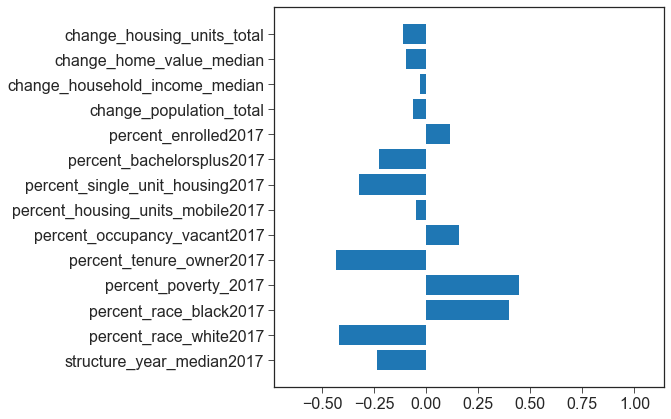

In [28]:
f, ax = plt.subplots(figsize=(7,7))
centroid_plot(ax, features, pca_objs[0].components_[0])

In [29]:
print("Percent difference from eligible but not picked tracts.")
for i in range(len(features)):
    e_feature = X_n.iloc[:, i]
    avg_e = np.mean(e_feature)
    oz_feature = X.iloc[:, i]
    avg_oz = np.mean(oz_feature)
    pdiff = (avg_oz - avg_e) / avg_e
    z, prob = wstats.ztest(e_feature, oz_feature)
    print("{}% (p={}) –– {}".format( round(pdiff*100, 2), round(prob, 3), features[i]))

Percent difference from eligible but not picked tracts.
-1.42% (p=0.031) –– structure_year_median2017
-1.87% (p=0.0) –– percent_race_white2017
6.2% (p=0.002) –– percent_race_black2017
2.21% (p=0.02) –– percent_poverty_2017
-1.16% (p=0.009) –– percent_tenure_owner2017
1.2% (p=0.286) –– percent_occupancy_vacant2017
0.38% (p=0.862) –– percent_housing_units_mobile2017
-1.31% (p=0.004) –– percent_single_unit_housing2017
0.1% (p=0.899) –– percent_bachelorsplus2017
0.14% (p=0.925) –– percent_enrolled2017
-5.58% (p=0.223) –– change_population_total
1.43% (p=0.548) –– change_household_income_median
1.79% (p=0.624) –– change_home_value_median
-5.65% (p=0.211) –– change_housing_units_total
